# Visualización de datos Copernicus Sentinel-2


En este notebook aprenderemos a visualizar datos de las coleeciones de Sentinel-2

### Importar librerias

In [2]:
import openeo
import xarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

### Credenciales

In [3]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with NullAuth>

In [10]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

### Llamar la colección de Sentinel-2 y ROI

In [35]:
#Defina un área de interés ROI
polygon_coordinates = [
    [-85.39270927570222, 10.244649389003081],
    [-85.18019249103425, 10.244649389003081],
    [-85.18019249103425, 10.408463720874975],
    [-85.39270927570222, 10.408463720874975],
    [-85.39270927570222, 10.244649389003081]
]

# Criterios de la coleeción si soy 
s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=("2023-01-01", "2023-06-30"),  # puede ajustar las fechas a su criterio considere el tiempo de 
    spatial_extent={
        "type": "Polygon",
        "coordinates": [polygon_coordinates],
        "crs": "EPSG:4326",
    },
    bands=["B08","B04", "B03", "B02", "SCL"],       #ajuste a las bandas que considere necesario
    max_cloud_cover=50,                             #porcentaje de nubes
)

### Convertir en 

Los archivos netCDF (Network Common Data Form) son un formato de datos que se utiliza principalmente para almacenar y distribuir datos científicos.

- Los archivos netCDF son independientes de la plataforma y sistema operativo, se pueden compartir y utilizar en diferentes sistemas sin necesidad de conversión.
- Permiten el almacenamiento de datos en forma de matrices multidimensionales (Temperatura, presíón, precipitación, etc).
- Permiten almacenar información detallada de los datos (dimensiones, variables y atributos).
- Pueden manejar grandes volúmenes de datos de manera eficiente.
- Es un estándar abierto.
- Múltiples librerias específicas para trabajar con datos netCDF en distintos lenguajes de programación (Python, C/C++, MATLAB, entre otros).

Puede encontrar mayor información en [unidata](https://www.unidata.ucar.edu/software/netcdf/)

![netCDF](https://desktop.arcgis.com/es/arcmap/latest/manage-data/netcdf/GUID-1D7240CD-54D4-45FF-A150-43B1AFFBF7D6-web.gif)


### Descargar el netCDF

In [14]:
%time s2_cube.download("S2_afolu.nc")

CPU times: user 459 ms, sys: 1.02 s, total: 1.48 s
Wall time: 4min 59s


### Abrir y analizar nuestro netCDF

In [16]:

# Abre el archivo NetCDF
dataset = xr.open_dataset('S2_afolu.nc')

# Muestra la información del archivo
dataset

<xarray.Dataset>
Dimensions:  (t: 24, x: 2339, y: 1825)
Coordinates:
  * t        (t) datetime64[ns] 2023-01-03 2023-01-08 ... 2023-05-23 2023-06-12
  * x        (x) float64 6.759e+05 6.76e+05 6.76e+05 ... 6.993e+05 6.993e+05
  * y        (y) float64 1.151e+06 1.151e+06 1.151e+06 ... 1.133e+06 1.133e+06
Data variables:
    crs      |S1 ...
    B08      (t, y, x) float32 ...
    B04      (t, y, x) float32 ...
    B03      (t, y, x) float32 ...
    B02      (t, y, x) float32 ...
    SCL      (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

### Visualización incial
Explore las combinaciones de bandas y fechas a dispocisión (t) con las bandas a dispocisión (omita la SLC). 


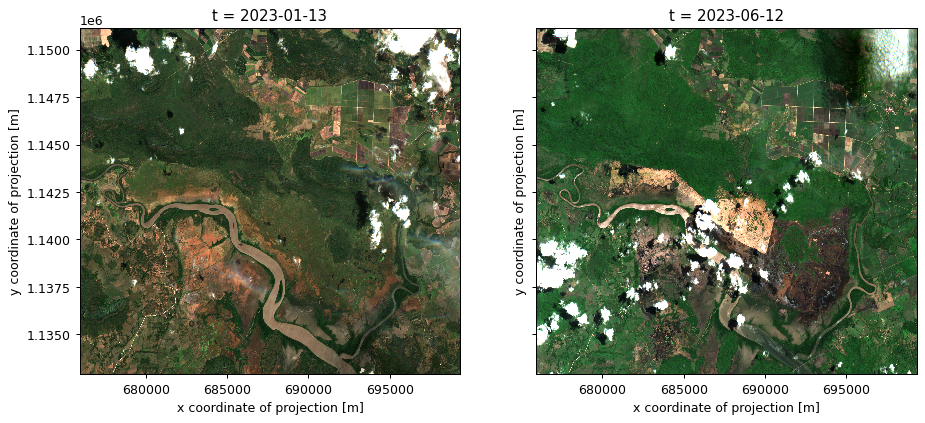

In [19]:
ds = xarray.load_dataset('S2_afolu.nc')
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")

fig, axes = plt.subplots(ncols=2, figsize=(12, 5), dpi=90, sharey=True)
data[{"t": 2}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
data[{"t": -1}].plot.imshow(vmin=0, vmax=2000, ax=axes[1]);

#ajuste el valor t para revisar diferentes momentos de la serie temporal



### Incorporar nuevas variables

In [20]:
# El dataset .nc se cargó previamente

# Calcular NDVI
ndvi = (dataset['B08'] - dataset['B04']) / (dataset['B08'] + dataset['B04'])

# Asegurarse de que el NDVI tenga el mismo nombre de coordenadas y atributos
ndvi.name = 'NDVI'
ndvi.attrs['long_name'] = 'Normalized Difference Vegetation Index'
ndvi.attrs['units'] = '1'

# Agregar NDVI al dataset original
dataset['NDVI'] = ndvi

# Guardar el dataset actualizado en un nuevo archivo NetCDF
dataset.to_netcdf('S2_afolu_with_ndvi.nc')

print("NDVI calculado y agregado al archivo NetCDF.")

dataset

NDVI calculado y agregado al archivo NetCDF.


<xarray.Dataset>
Dimensions:  (t: 24, x: 2339, y: 1825)
Coordinates:
  * t        (t) datetime64[ns] 2023-01-03 2023-01-08 ... 2023-05-23 2023-06-12
  * x        (x) float64 6.759e+05 6.76e+05 6.76e+05 ... 6.993e+05 6.993e+05
  * y        (y) float64 1.151e+06 1.151e+06 1.151e+06 ... 1.133e+06 1.133e+06
Data variables:
    crs      |S1 ...
    B08      (t, y, x) float32 ...
    B04      (t, y, x) float32 ...
    B03      (t, y, x) float32 ...
    B02      (t, y, x) float32 ...
    SCL      (t, y, x) float32 ...
    NDVI     (t, y, x) float32 0.2464 0.229 0.2142 ... 0.8609 0.8617 0.8405
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

# Visualicemos nuestro nueva variable

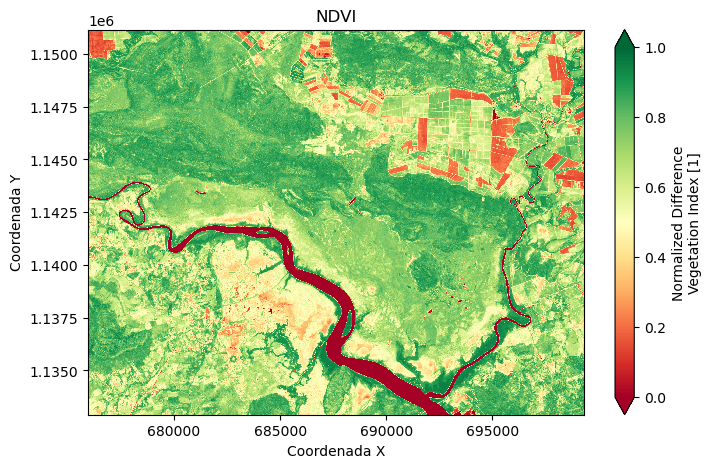

In [27]:

# Abrir el archivo NetCDF que contiene el NDVI
dataset = xr.open_dataset('S2_afolu_with_ndvi.nc')

# Seleccionar un tiempo específico para visualizar el NDVI
# Aquí seleccionamos la primera fecha disponible en la dimensión 't'
ndvi = dataset['NDVI'].isel(t=0)   #camie el valor de t a discreción

# Crear una figura y un eje para la visualización
plt.figure(figsize=(8, 5))

# Visualizar el NDVI
ndvi.plot(cmap='RdYlGn', vmin=0, vmax=1)

# Añadir título y etiquetas a la imagen
plt.title('NDVI')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')

# Mostrar la imagen
plt.show()


#### Comparemos diferentes fechas

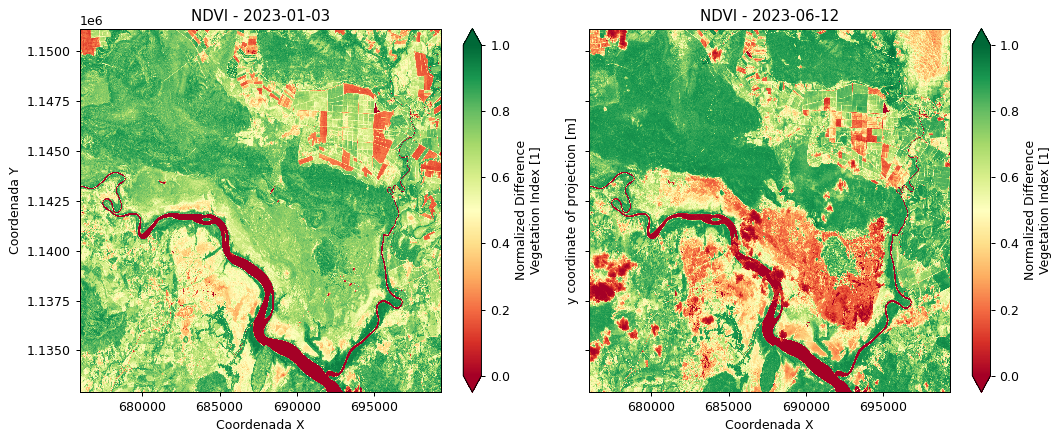

In [28]:
# Cargar el archivo NetCDF con el NDVI
ds = xr.open_dataset('S2_afolu_with_ndvi.nc')

# Crear una figura con dos subplots
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), dpi=90, sharey=True)

# Seleccionar las fechas para las dos imágenes de NDVI
# Cambia los índices en "isel" para seleccionar diferentes fechas
ndvi_date1 = ds["NDVI"].isel(t=0)  # Primera fecha
ndvi_date2 = ds["NDVI"].isel(t=-1)  # Última fecha

# Extraer las fechas de la dimensión 't'
date1 = str(ndvi_date1['t'].values)[:10]  # Obtener la fecha en formato 'YYYY-MM-DD'
date2 = str(ndvi_date2['t'].values)[:10] 

# Visualizar la primera imagen de NDVI
ndvi_date1.plot.imshow(ax=axes[0], cmap='RdYlGn', vmin=0, vmax=1)
axes[0].set_title(f'NDVI - {date1}')  # Título con la fecha extraída

# Visualizar la segunda imagen de NDVI
ndvi_date2.plot.imshow(ax=axes[1], cmap='RdYlGn', vmin=0, vmax=1)
axes[1].set_title(f'NDVI - {date2}')  

# Añadir etiquetas a los ejes
for ax in axes:
    ax.set_xlabel('Coordenada X')
axes[0].set_ylabel('Coordenada Y')

# Ajustar y mostrar las imágenes
plt.tight_layout()
plt.show()


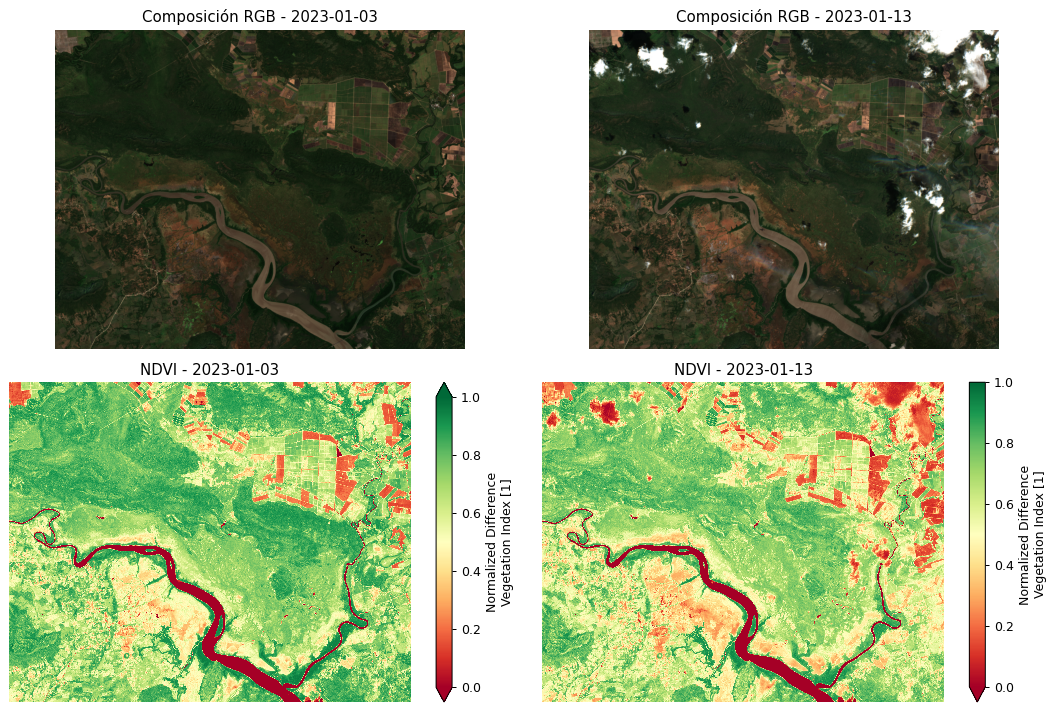

In [29]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Cargar el archivo NetCDF con el NDVI
ds = xr.open_dataset('S2_afolu_with_ndvi.nc')

# Seleccionar las fechas para las dos imágenes de NDVI y RGB
ndvi_date1 = ds.isel(t=0)  # Primera fecha
ndvi_date2 = ds.isel(t=2)  # Última fecha

# Extraer las fechas de la dimensión 't'
date1 = str(ndvi_date1['t'].values)[:10]  # Obtener la fecha en formato 'YYYY-MM-DD'
date2 = str(ndvi_date2['t'].values)[:10]  # Obtener la fecha en formato 'YYYY-MM-DD'

# Función para crear la composición RGB
def create_rgb_image(data, bands, min_val=0, max_val=1):
    norm_bands = []
    for band in bands:
        band_data = data[band].values
        band_data = np.clip(band_data, min_val, max_val)  # Clip the data to the given range
        norm_band = (band_data - min_val) / (max_val - min_val)  # Normalize the data
        norm_bands.append(norm_band)
    rgb = np.stack(norm_bands, axis=-1)
    return rgb

# Crear una figura con cuatro subplots para la visualización
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=90)

# Ajustar los valores de mínimo y máximo para las bandas RGB
min_val = 0  # Ajusta este valor según sea necesario
max_val = 3000  # Ajusta este valor según sea necesario

# Visualizar la composición RGB para la primera fecha
rgb_image1 = create_rgb_image(ndvi_date1, ['B04', 'B03', 'B02'], min_val, max_val)
axes[0, 0].imshow(rgb_image1)
axes[0, 0].set_title(f'Composición RGB - {date1}')
axes[0, 0].axis('off')

# Visualizar la composición RGB para la segunda fecha
rgb_image2 = create_rgb_image(ndvi_date2, ['B04', 'B03', 'B02'], min_val, max_val)
axes[0, 1].imshow(rgb_image2)
axes[0, 1].set_title(f'Composición RGB - {date2}')
axes[0, 1].axis('off')

# Visualizar la primera imagen de NDVI
ndvi_date1['NDVI'].plot.imshow(ax=axes[1, 0], cmap='RdYlGn', vmin=0, vmax=1)
axes[1, 0].set_title(f'NDVI - {date1}')
axes[1, 0].axis('off')

# Visualizar la segunda imagen de NDVI
ndvi_date2['NDVI'].plot.imshow(ax=axes[1, 1], cmap='RdYlGn', vmin=0, vmax=1)
axes[1, 1].set_title(f'NDVI - {date2}')
axes[1, 1].axis('off')

# Añadir etiquetas a los ejes
for ax in axes[1, :]:
    ax.set_xlabel('Coordenada X')
axes[1, 0].set_ylabel('Coordenada Y')

# Ajustar y mostrar las imágenes
plt.tight_layout()
plt.show()



### Analicemos más datos

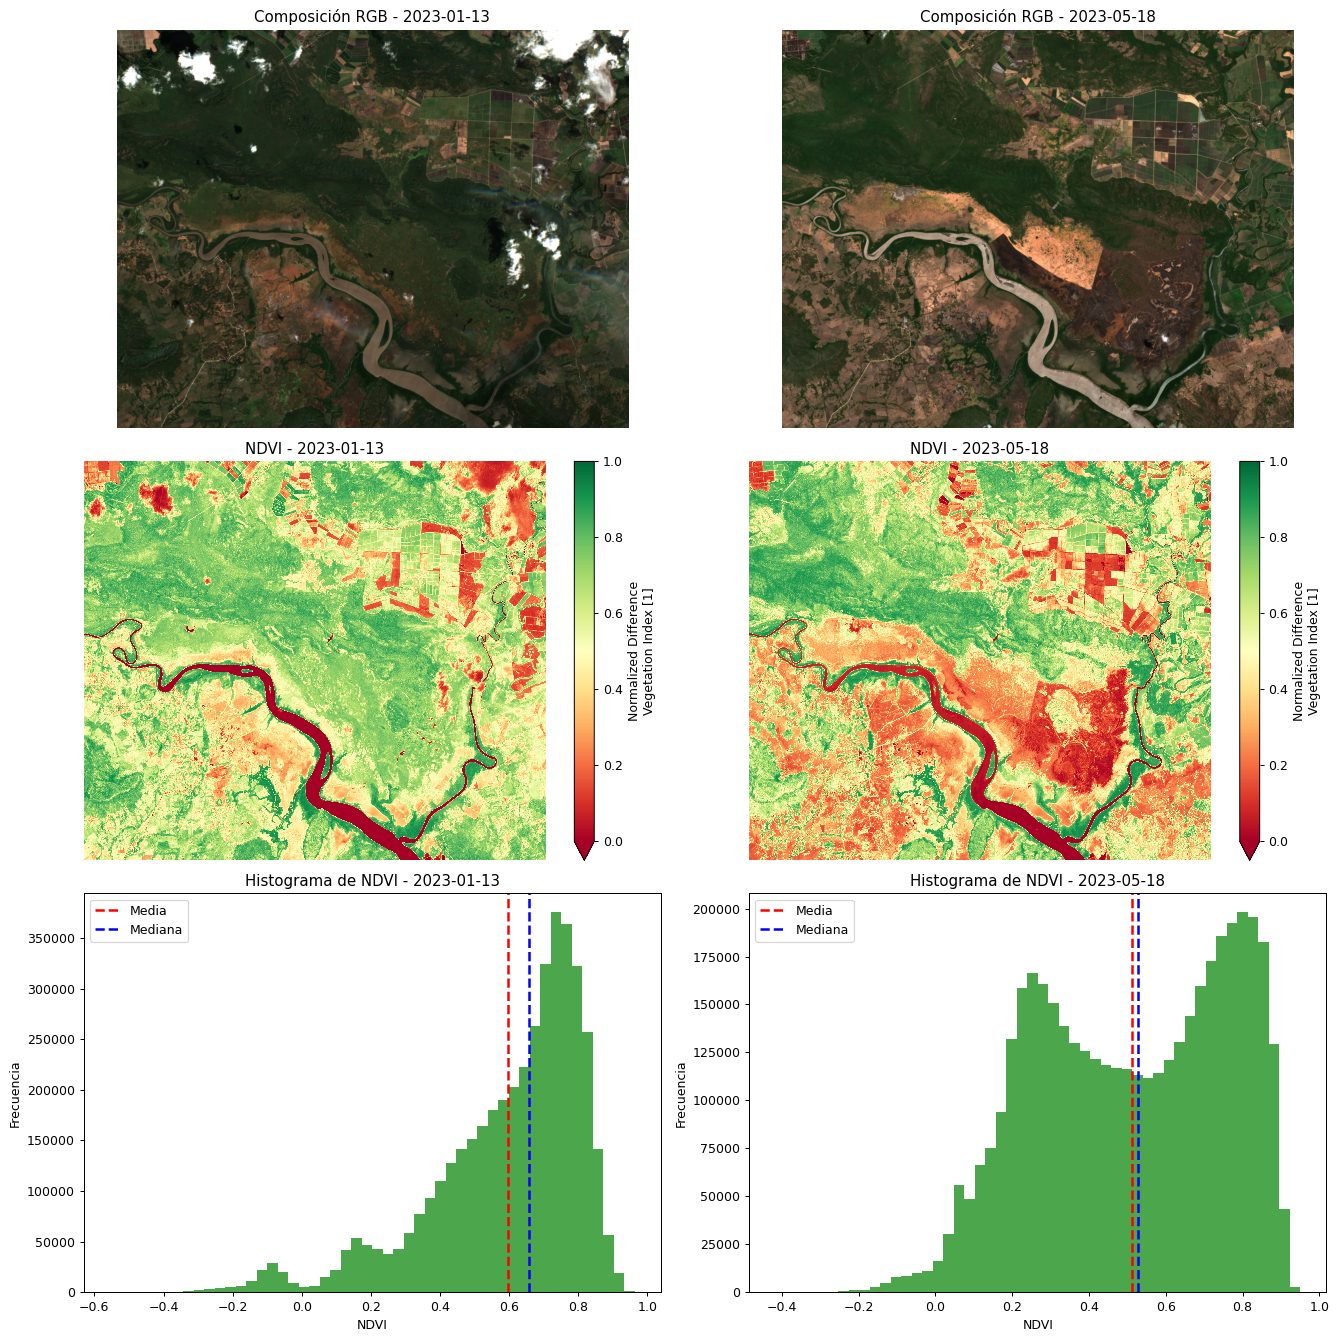

In [34]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Cargar el archivo NetCDF con el NDVI
ds = xr.open_dataset('S2_afolu_with_ndvi.nc')

# Seleccionar las fechas para las dos imágenes de NDVI y RGB
ndvi_date1 = ds.isel(t=2)  # Primera fecha
ndvi_date2 = ds.isel(t=-3)  # Última fecha

# Extraer las fechas de la dimensión 't'
date1 = str(ndvi_date1['t'].values)[:10]  # Obtener la fecha en formato 'YYYY-MM-DD'
date2 = str(ndvi_date2['t'].values)[:10]  # Obtener la fecha en formato 'YYYY-MM-DD'

# Función para crear la composición RGB
def create_rgb_image(data, bands, min_val=0, max_val=1):
    norm_bands = []
    for band in bands:
        band_data = data[band].values
        band_data = np.clip(band_data, min_val, max_val)  # Clip the data to the given range
        norm_band = (band_data - min_val) / (max_val - min_val)  # Normalize the data
        norm_bands.append(norm_band)
    rgb = np.stack(norm_bands, axis=-1)
    return rgb

# Crear una figura con seis subplots para la visualización
fig, axes = plt.subplots(3, 2, figsize=(15, 15), dpi=90)

# Ajustar los valores de mínimo y máximo para las bandas RGB
min_val = 0  # Ajusta este valor según sea necesario
max_val = 3000  # Ajusta este valor según sea necesario

# Visualizar la composición RGB para la primera fecha
rgb_image1 = create_rgb_image(ndvi_date1, ['B04', 'B03', 'B02'], min_val, max_val)
axes[0, 0].imshow(rgb_image1)
axes[0, 0].set_title(f'Composición RGB - {date1}')
axes[0, 0].axis('off')

# Visualizar la composición RGB para la segunda fecha
rgb_image2 = create_rgb_image(ndvi_date2, ['B04', 'B03', 'B02'], min_val, max_val)
axes[0, 1].imshow(rgb_image2)
axes[0, 1].set_title(f'Composición RGB - {date2}')
axes[0, 1].axis('off')

# Visualizar la primera imagen de NDVI
ndvi_date1['NDVI'].plot.imshow(ax=axes[1, 0], cmap='RdYlGn', vmin=0, vmax=1)
axes[1, 0].set_title(f'NDVI - {date1}')
axes[1, 0].axis('off')

# Visualizar la segunda imagen de NDVI
ndvi_date2['NDVI'].plot.imshow(ax=axes[1, 1], cmap='RdYlGn', vmin=0, vmax=1)
axes[1, 1].set_title(f'NDVI - {date2}')
axes[1, 1].axis('off')

# Visualizar el histograma de NDVI para la primera fecha
ndvi_values1 = ndvi_date1['NDVI'].values.flatten()
ndvi_values1 = ndvi_values1[~np.isnan(ndvi_values1)]  # Eliminar NaNs
axes[2, 0].hist(ndvi_values1, bins=50, color='green', alpha=0.7)
axes[2, 0].set_title(f'Histograma de NDVI - {date1}')
axes[2, 0].set_xlabel('NDVI')
axes[2, 0].set_ylabel('Frecuencia')

# Calcular y marcar la media y la mediana en el histograma
mean1 = np.mean(ndvi_values1)
median1 = np.median(ndvi_values1)
axes[2, 0].axvline(mean1, color='red', linestyle='dashed', linewidth=2, label='Media')
axes[2, 0].axvline(median1, color='blue', linestyle='dashed', linewidth=2, label='Mediana')
axes[2, 0].legend()

# Visualizar el histograma de NDVI para la segunda fecha
ndvi_values2 = ndvi_date2['NDVI'].values.flatten()
ndvi_values2 = ndvi_values2[~np.isnan(ndvi_values2)]  # Eliminar NaNs
axes[2, 1].hist(ndvi_values2, bins=50, color='green', alpha=0.7)
axes[2, 1].set_title(f'Histograma de NDVI - {date2}')
axes[2, 1].set_xlabel('NDVI')
axes[2, 1].set_ylabel('Frecuencia')

# Calcular y marcar la media y la mediana en el histograma
mean2 = np.mean(ndvi_values2)
median2 = np.median(ndvi_values2)
axes[2, 1].axvline(mean2, color='red', linestyle='dashed', linewidth=2, label='Media')
axes[2, 1].axvline(median2, color='blue', linestyle='dashed', linewidth=2, label='Mediana')
axes[2, 1].legend()

# Ajustar y mostrar las imágenes
plt.tight_layout()
plt.show()


### Acá finalizamos este ejercicio de visualización

Retos

- Enmascarar las zonas de nubes de las imágenes, para esto se puede usar la banda SLC.
- Crear otros indices espectrales
